# Libraries

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
from textblob import TextBlob
from os.path import exists
import nltk
nltk.download('averaged_perceptron_tagger')

import re

# Flesch-Kincaid readability calculation
def flesch_kincaid(text):
    if not text or len(text.strip()) == 0:
        return 0
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    num_syllables = sum([count_syllables(word) for word in words])

    # Flesch-Kincaid formula
    if num_words > 0 and num_sentences > 0:
        fk_score = 206.835 - 1.015 * (num_words / num_sentences) - 84.6 * (num_syllables / num_words)
        return fk_score
    else:
        return 0

# Helper function to count syllables in a word
def count_syllables(word):
    word = word.lower()
    vowels = "aeiouy"
    syllable_count = 0
    previous_char_was_vowel = False
    for char in word:
        if char in vowels:
            if not previous_char_was_vowel:
                syllable_count += 1
            previous_char_was_vowel = True
        else:
            previous_char_was_vowel = False
    if word.endswith("e"):
        syllable_count = max(1, syllable_count - 1)
    return syllable_count


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\M1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

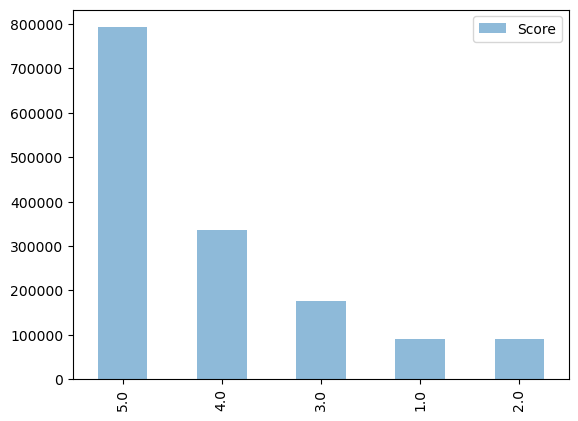


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [17]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [13]:
def add_features_to(df):
    # Helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Enhanced sentiment using TextBlob (polarity and subjectivity)
    df['polarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['subjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # Word count and readability score
    df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['flesch_kincaid'] = df['Text'].apply(lambda x: flesch_kincaid(str(x)))

    # POS tagging for adjectives and adverbs
    def count_pos_tags(text, pos_tag):
        tokens = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        return sum(1 for word, tag in pos_tags if tag.startswith(pos_tag))

    df['num_adjectives'] = df['Text'].apply(lambda x: count_pos_tags(str(x), 'JJ'))
    df['num_adverbs'] = df['Text'].apply(lambda x: count_pos_tags(str(x), 'RB'))

    print(df.columns)
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [14]:
# Handle imbalance by downsampling the majority class
majority = X_train[X_train['Score'] == 5.0]
minority = X_train[X_train['Score'] != 5.0]
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
balanced_trainingSet = pd.concat([majority_downsampled, minority])

# Feature Selection

In [15]:
# Define features and target
features = ['Helpfulness', 'polarity', 'subjectivity', 'word_count', 'flesch_kincaid', 'num_adjectives', 'num_adverbs']
X = balanced_trainingSet[features]
y = balanced_trainingSet['Score'] - 1

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

KeyError: "['word_count', 'flesch_kincaid', 'num_adjectives', 'num_adverbs'] not in index"

# Model Creation

In [6]:
# Set up parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1],         # Lower learning rates for fine-tuning
    'n_estimators': [100, 300, 500],      # Number of boosting rounds
    'max_depth': [3, 5, 7],               # Tree depth for model complexity
    'subsample': [0.6, 0.8]               # Fraction of data to use per tree
}

# Initialize the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True  # To get train scores in results
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Retrieve and display the accuracy for each parameter combination
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Params: {params}, Mean CV Accuracy: {mean_score:.4f}")

# Use the best estimator from GridSearchCV to predict on the test set
best_model = grid_search.best_estimator_

# Predict and evaluate on the validation set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\M1\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:48] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy:  0.5318843804146717
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}, Mean CV Accuracy: 0.5178
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}, Mean CV Accuracy: 0.5177
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}, Mean CV Accuracy: 0.5176
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, Mean CV Accuracy: 0.5177
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}, Mean CV Accuracy: 0.5214
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}, Mean CV Accuracy: 0.5212
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}, Mean CV Accuracy: 0.5258
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_esti

# Model Evaluation

Accuracy on testing set = 0.5312448532024999


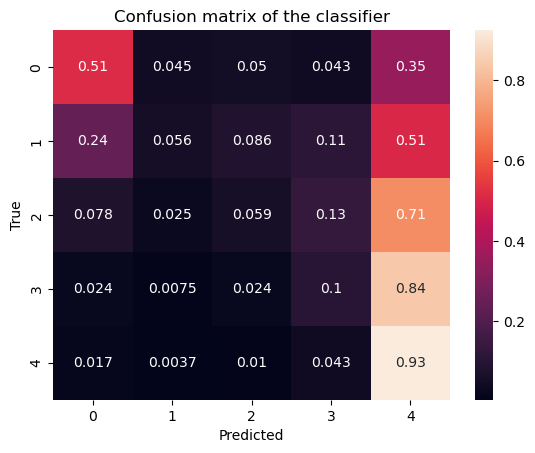

In [9]:
# Evaluate your model on the testing set
print(f"Accuracy on testing set = {accuracy}")

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [8]:
# Prepare the test set for prediction
X_submission = add_features_to(X_submission)
X_submission_select = X_submission[features]

# Create the submission file
X_submission['Score'] = best_model.predict(X_submission_select) + 1.0
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

print("Submission file created: submission.csv")

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Helpfulness',
       'polarity', 'subjectivity', 'review_length', 'Score'],
      dtype='object')
Submission file created: submission.csv
